# Bulge / Total exploration

This notebook reads in files created elsewhere containing galaxy builder models (aggregate, best individual and optimized best individual) and compares the Bulge / Total fraction to results in the literature

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
import os
import json
import numpy as np
import pandas as pd
from copy import deepcopy
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import lib.galaxy_utilities as gu
import gzbuilder_analysis.parsing as parsing
import gzbuilder_analysis.aggregation as aggregation
import gzbuilder_analysis.rendering as rendering
from gzbuilder_analysis.rendering.jax.sersic import _b, sersic_ltot
import gzbuilder_analysis.fitting as fitting
import gzbuilder_analysis.fitting.jax as f_j
import jax.numpy as jnp
from asinh_cmap import asinh_cmap
from IPython.display import HTML

Read in the required files:

In [4]:
fitting_metadata = pd.read_pickle('lib/fitting_metadata.pkl').sort_index()

In [5]:
sid_list = np.loadtxt('lib/subject-id-list.csv', dtype='u8')

# catalogues to compare to
simard_df = pd.read_csv('lib/simard-catalog_fixed-n.csv', index_col=0)
simard_df_free = pd.read_csv('lib/simard-catalog_free-n.csv', index_col=0)
lackner_nb1 = pd.read_csv('lib/lackner_nb1.csv', index_col=0)
lackner_nb4 = pd.read_csv('lib/lackner_nb4.csv', index_col=0)

# # GZB results
# models = pd.read_pickle('lib/models2.pickle')

# # GZB modelling data
# gal_angle_df = pd.read_csv('lib/gal-metadata.csv', index_col=0)
# diff_data_df = pd.read_pickle('lib/fitting_metadata.pkl')

In [6]:
agg_res_path = 'output_files/aggregation_results'
agg_results = pd.Series([], dtype=object)
with tqdm(os.listdir(agg_res_path)) as bar:
    for f in bar:
         if re.match(r'[0-9]+\.pkl.gz', f):
                agg_results[int(f.split('.')[0])] = pd.read_pickle(
                    os.path.join(agg_res_path, f)
                )

100%|██████████| 296/296 [00:02<00:00, 99.91it/s] 


In [7]:
fit_model_path = 'output_files/tuning_results'
fit_models = pd.Series([], dtype=object)
with tqdm(os.listdir(fit_model_path)) as bar:
    for f in bar:
         if re.match(r'[0-9]+\.pickle.gz', f):
                fit_models[int(f.split('.')[0])] = pd.read_pickle(
                    os.path.join(fit_model_path, f)
                )
fit_models = fit_models.apply(pd.Series)

100%|██████████| 297/297 [00:00<00:00, 366.82it/s]


In [8]:
p_fit = fit_models.res.apply(pd.Series).x

In [9]:
optimizers = pd.Series([], dtype=object)
with tqdm(fit_models.index) as bar:
    for subject_id in bar:
        fm = fitting_metadata.loc[subject_id]
        o = f_j.Optimizer(
            agg_results.loc[subject_id],
            fitting_metadata.loc[subject_id]
        )
        o.reset_keys()
        optimizers[subject_id] = o

  0%|          | 0/296 [00:00<?, ?it/s]/Users/tlingard/anaconda3/lib/python3.6/site-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
100%|██████████| 296/296 [00:45<00:00,  6.56it/s]


In [10]:
# def spiral_rotation_correction(model, original_model):
#     dpsi = model['disk']['roll'] - original_model['disk']['roll']
#     try:
#         new_spirals = model['spiral'].copy()
#         i = 0
#         while True:
#             try:
#                 Ap = model['spiral'][f'A.{i}'] * np.exp(dpsi * np.tan(np.deg2rad(model['spiral'][f'phi.{i}'])))
#                 t_min_p = model['spiral'][f't_min.{i}'] - dpsi
#                 t_max_p = model['spiral'][f't_min.{i}'] - dpsi
#                 new_spirals.update(pd.Series({f'A.{i}': Ap, f't_min.{i}': t_min_p, f't_max.{i}': t_max_p}))
#                 i += 1
#             except KeyError:
#                 break
#         new_spirals = pd.Series(new_spirals)
#         new_spirals.index = pd.MultiIndex.from_product((['spiral'], new_spirals.index))
#         return new_spirals.combine_first(model)
#     except KeyError:
#         return model.copy()

In [11]:
models = fit_models.final_model.apply(
    lambda m: pd.DataFrame(m).unstack().dropna()
)

In [12]:
corrected_models = (
    agg_results.index.to_series().apply(
        lambda idx: f_j.spiral_rotation_correction(models.loc[idx].dropna(), agg_results.loc[idx].model)
    )
)

In [13]:
def get_bulge_tot(subject_id):
    model = models.loc[subject_id]
    if model['bulge'].isna().any():
        return 0
    base_model = agg_results.loc[subject_id].model
    (cx, cy), (cx_super, cy_super) = f_j._make_xy_arrays(optimizers.loc[subject_id].target, 5)
    n_spirals = len(model['spiral'].dropna()) // 6
    distances = f_j._get_distances(
        cx, cy, model, base_model, n_spirals)
    disk_super = f_j.sersic(
        cx_super, cy_super, model['disk']['mux'], model['disk']['muy'],
        model['disk']['roll'], model['disk']['q'], 2.0,
        model['disk']['I'], model['disk']['Re'], 1.0
    )
    bulge_super = f_j.sersic(
        cx_super, cy_super, model['bulge']['mux'], model['bulge']['muy'],
        model['bulge']['roll'], model['bulge']['q'], 2.0,
        model['bulge']['I'], model['bulge']['Re'], model['bulge']['n']
    ) if not np.any(model['bulge'].isna()) else jnp.zeros_like(disk_super)
    bar_super = f_j.sersic(
        cx_super, cy_super, model['bar']['mux'], model['bar']['muy'],
        model['bar']['roll'], model['bar']['q'], model['bar']['c'],
        model['bar']['I'], model['bar']['Re'], model['bar']['n']
    ) if not np.any(model['bar'].isna()) else 0
    Is = jnp.array([model['spiral']['I.{}'.format(i)] for i in range(n_spirals)])
    spreads = jnp.array([
        model['spiral']['spread.{}'.format(i)] for i in range(n_spirals)
    ])
    spiral_disks = f_j.downsample(f_j.sersic(
        jnp.expand_dims(cx_super, -1),
        jnp.expand_dims(cy_super, -1),
        model['disk']['mux'], model['disk']['muy'],
        model['disk']['roll'], model['disk']['q'], 2.0,
        model['disk']['I'], model['disk']['Re'], 1.0
    ))
    spiral = jnp.sum(
        Is
        * jnp.exp(-distances**2 / (2*spreads**2))
        * spiral_disks,
        axis=-1
    )
    galaxy = f_j.downsample(disk_super + bulge_super + bar_super)[:, :, 0] + spiral
    return f_j.downsample(bulge_super).sum() / galaxy.sum()

In [14]:
# from matplotlib.patches import Ellipse
# def rot_matrix(a):
#     return np.array((
#         (np.cos(a), np.sin(a)),
#         (-np.sin(a), np.cos(a))
#     ))


# def _logsp(t_min, t_max, A, phi, q, psi, dpsi, mux, muy, N):
#     theta = np.linspace(t_min, t_max, N)
#     LSP = A * np.exp(np.tan(np.deg2rad(phi)) * theta)
#     qmx = np.array(((q, 0), (0, 1)))
#     mx = np.dot(rot_matrix(-psi), np.dot(qmx, rot_matrix(dpsi)))
#     return (
#         LSP * np.dot(mx, np.array((np.cos(theta), np.sin(theta))))
#     ).T + np.array([mux, muy])

# def _logsp2(t_min, t_max, A, phi, q, psi, dpsi, mux, muy, N):
#     Ap = A * np.exp(-dpsi * np.tan(np.deg2rad(phi)))
#     t_min_p = t_min# + dpsi
#     t_max_p = t_max# + dpsi
#     theta = np.linspace(t_min_p, t_max_p, N)
#     LSP = Ap * np.exp(np.tan(np.deg2rad(phi)) * theta)
#     qmx = np.array(((q, 0), (0, 1)))
#     mx = np.dot(rot_matrix(-psi), np.dot(qmx, rot_matrix(dpsi)))
#     return (
#         LSP * np.dot(mx, np.array((np.cos(theta), np.sin(theta))))
#     ).T + np.array([mux, muy])


# d = dict(mux=0, muy=0, q=0.6, Re=1, roll=0)

# gen_args = lambda dpsi: (0, 2 * np.pi, 1, 10, d['q'], d['roll'] + dpsi, dpsi, d['mux'], d['muy'], 200)

# plt.figure(figsize=(6, 6), dpi=120)
# plt.axis('equal')
# plt.gca().add_patch(Ellipse((d['mux'], d['muy']), width=d['Re']*d['q'], height=d['Re'], angle=d['roll'], fc='none', ec='C0'))
# dpsi = 0
# # plt.plot(*np.squeeze(np.dot(rot_matrix(-dpsi), np.expand_dims(_logsp(*gen_args(dpsi)), -1))), f'--k')
# plt.plot(*_logsp(*gen_args(dpsi)).T, 'k', lw=5, alpha=0.5)
# for i, dpsi in enumerate(np.linspace(0, 1, 20)):
# #     plt.plot(*np.squeeze(np.dot(rot_matrix(dpsi), np.expand_dims(_logsp(*gen_args(dpsi)), -1))), f'--C{2*i}')
# #     plt.plot(*np.squeeze(np.dot(rot_matrix(dpsi), np.expand_dims(_logsp2(*gen_args(dpsi)), -1))), f':C{2*i+1}')
#     plt.plot(*_logsp(*gen_args(dpsi)).T, f':C{(2*i+1)%10}')
# #     plt.plot(*_logsp2(*gen_args(dpsi)).T, f':C{(2*i+1)%10}')

Now we render every galaxy, and calculate the ratio of bulge total luminosity to galaxy total luminosity: (can't do this analytically as ellipticity and boxyness alter the Luminosity value in a non-obvious way!

In [15]:
bulge_frac = pd.Series([], dtype=float)
with tqdm(models.index.values) as bar:
    for sid in bar:
        bulge_frac[sid] = float(get_bulge_tot(sid))

100%|██████████| 296/296 [07:41<00:00,  1.56s/it]


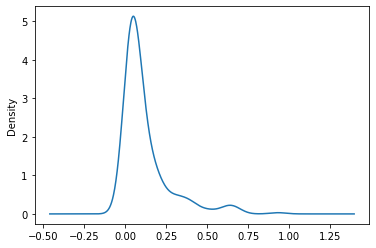

In [16]:
bulge_frac.replace(0, np.nan).dropna().plot.kde()

In [17]:
catalog_results = pd.concat((
  simard_df[['__B_T_r', 'e__B_T_r']]
    .rename(columns=dict(__B_T_r='Sbt', e__B_T_r='eSbt')),
  simard_df_free[['__B_T_r', 'e__B_T_r']]
    .rename(columns=dict(__B_T_r='Sbt_free', e__B_T_r='eSbt_free')),
  lackner_nb1[['BULGE_TO_TOT_R', 'BULGE_TO_TOT_R_ERR']]
    .rename(columns=dict(BULGE_TO_TOT_R='Lbt1', BULGE_TO_TOT_R_ERR='eLbt1')),
  lackner_nb4[['BULGE_TO_TOT_R', 'BULGE_TO_TOT_R_ERR']]
    .rename(columns=dict(BULGE_TO_TOT_R='Lbt4', BULGE_TO_TOT_R_ERR='eLbt4')),
), axis=1)

display_column_map = dict(
  Sbt='Exponential + De Vaucoulers\n(Simard, 2011)',
  Sbt_free='Exponential + Sersic\n(Simard, 2011)',
  Lbt1='Exponential + Exponential\n(Lackner, 2012)',
  Lbt4='Exponential + De Vaucoulers\n(Lackner, 2012)',
)
catalog_results.rename(columns=display_column_map).describe()

,"Exponential + De Vaucoulers\n(Simard, 2011)",eSbt,"Exponential + Sersic\n(Simard, 2011)",eSbt_free,"Exponential + Exponential\n(Lackner, 2012)",eLbt1,"Exponential + De Vaucoulers\n(Lackner, 2012)",eLbt4
count,296.000000,296.000000,294.000000,294.000000,224.000000,224.000000,224.000000,224.000000
mean,0.157466,0.008885,0.292483,0.018061,0.108795,5923.105743,0.174067,0.023354
std,0.130613,0.010501,0.261888,0.031242,0.126834,51927.107199,0.174276,0.048144
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000298,0.000000,0.000713
25%,0.060000,0.000000,0.090000,0.000000,0.038871,0.001090,0.045580,0.002937
50%,0.120000,0.010000,0.195000,0.010000,0.065596,0.002073,0.115510,0.007436
75%,0.220000,0.010000,0.420000,0.020000,0.127879,0.004652,0.256837,0.021660
max,0.680000,0.110000,1.000000,0.230000,0.894223,545087.000000,0.901284,0.326977


What is the relationship between measured bulge to total fraction in our different catalogues? Does it vary with the best model type calculated by Lackner & Gunn (2012) (Pure 1-component Sersic or Exponential, or either an Exponential or Pseudo-Bulge)?

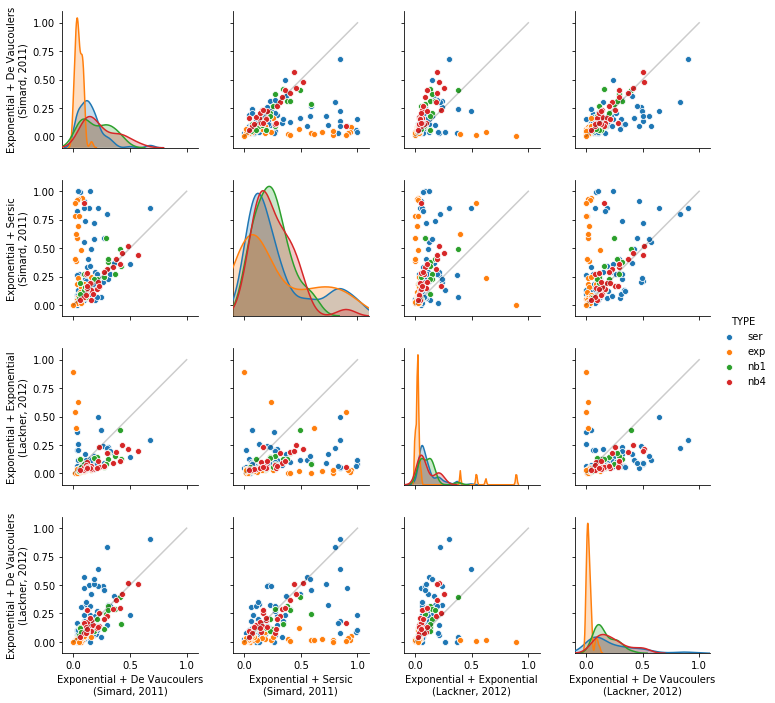

In [18]:
_df = pd.concat((
  catalog_results[['Sbt', 'Sbt_free', 'Lbt1', 'Lbt4']],
  lackner_nb1.query('TYPE != "dvc"')['TYPE'],
), axis=1).dropna()

g = sns.pairplot(
  _df.rename(columns=display_column_map),
  hue='TYPE',
)
offdiag = (ax for i, axs in enumerate(g.axes) for j, ax in enumerate(axs) if i != j)
for ax in offdiag:
  ax.add_line(plt.Line2D((0, 1), (0, 1), c='k', alpha=0.2))
  ax.set_xlim(-0.1, 1.1)
  ax.set_ylim(-0.1, 1.1)

Even when comparing the same model being fit by different surveys, we see a lot of scatter (though a notable 1:1 relationship). When Sérsic index for the bulge is fixed to 1, there is next to no agreement with other models, while a 

## Galaxy Builder measurements

We'll now introduce Galaxy Builder measurements into the mix!

First, initalise rendering Model objects for all the different kinds of model

Text(0, 0.5, 'Galaxy Builder Bulge Fraction')

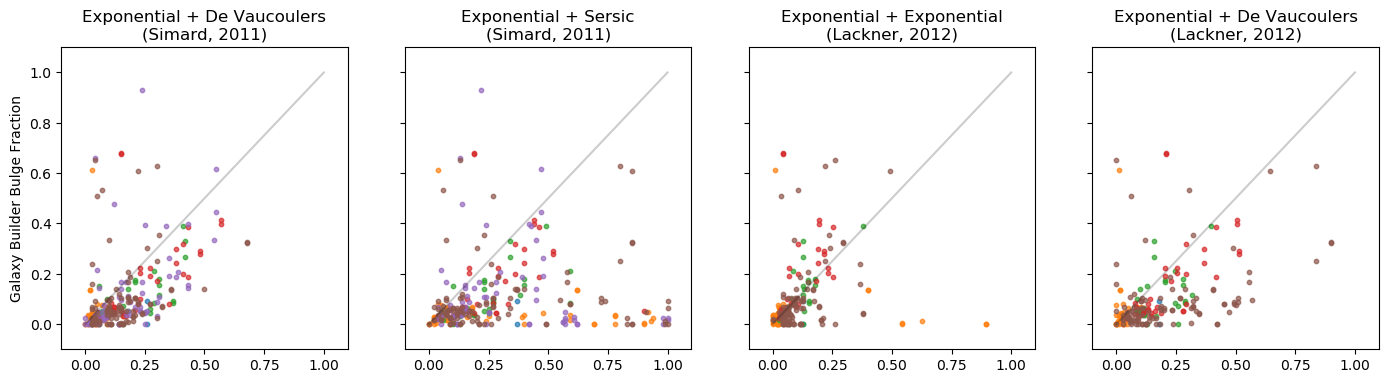

In [19]:
f, ax = plt.subplots(ncols=4, figsize=(17, 4), dpi=100, sharex=True, sharey=True)
model_types = lackner_nb1.reindex(catalog_results.index)['TYPE'].fillna('not_present')
for i, k in enumerate(('Sbt', 'Sbt_free', 'Lbt1', 'Lbt4')):
    for t in np.unique(model_types):
        if np.any(model_types == t):
            ax[i].scatter(
                catalog_results[k][model_types == t],
                bulge_frac.reindex(catalog_results.index)[model_types == t],
                alpha=0.7, s=10
            )
    ax[i].set_title(display_column_map.get(k, ''))
    ax[i].add_line(plt.Line2D((0, 1), (0, 1), c='k', alpha=0.2))

ax[0].set_xlim(-0.1, 1.1)
ax[0].set_ylim(-0.1, 1.1);
ax[0].set_ylabel('Galaxy Builder Bulge Fraction')